In [1]:
%reload_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as tfs
from torchvision import models
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# 是否使用GPU
use_gpu = False

In [3]:
# 数据增强
train_transform = tfs.Compose([
    # 训练集的数据预处理
    tfs.Resize([224, 224]),
    tfs.RandomHorizontalFlip(),
    tfs.RandomCrop(128),
    tfs.ToTensor(),
    tfs.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_transform = tfs.Compose([
    tfs.Resize([224,224]),
#     tfs.RandomCrop(128),
    tfs.ToTensor(),
    tfs.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [4]:
# 每一个batch的数据集数目
batch_size = 10

In [5]:
# 构建训练集和验证集
train_set = ImageFolder('./dataset1/train', train_transform)
train_data = DataLoader(train_set, batch_size, shuffle=True, num_workers=0)

valid_set = ImageFolder('./dataset1/valid', test_transform)
valid_data = DataLoader(valid_set, 2*batch_size, shuffle=False, num_workers=0)

In [6]:
train_set.class_to_idx

{'blank': 0, 'filled': 1, 'other': 2}

In [7]:
len(valid_data)

14

In [8]:
try:
    if iter(train_data).next()[0].shape[0] == batch_size and \
    iter(valid_data).next()[0].shape[0] == 2*batch_size:
        print('Dataset is ready!')
    else:
        print('Not success, maybe the batch size is wrong')
except:
    print('not success, image transform is wrong!')

Dataset is ready!


In [9]:
# 构建模型
def get_model():
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(2048, 3)
    return model

try:
    model = get_model()
    with torch.no_grad():
        scorce = model(iter(train_data).next()[0])
        print(scorce.shape[0], scorce.shape[1])
    if scorce.shape[0] == batch_size and scorce.shape[1] == 3:
        print('Model is ready!')
    else:
        print('Model is failed!')
except:
    print('model is wrong')

if use_gpu:
    model = model.cuda()

10 3
Model is ready!


In [10]:
# 构建loss函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

# 训练的epoches数目
max_epoch = 20

In [11]:
# 训练
def train(model, train_data, valid_data, max_epoch, criterion, optimizer):
    freq_print = int(len(train_data) / 3)
    
    metric_log = dict()
    metric_log['train_loss'] = list()
    metric_log['train_acc'] = list()
    if valid_data is not None:
        metric_log['valid_loss'] = list()
        metric_log['valid_acc'] = list()
    
    for e in range(max_epoch):
        model.train()
        running_loss = 0
        running_acc = 0

        for i, data in enumerate(train_data, 1):
            img, label = data
            if use_gpu:
                img = img.cuda()
                label = label.cuda()

            # forward前向传播
            out = model(img)

            # 计算误差
            loss = criterion(out, label.long())

            # 反向传播，更新参数
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 计算准确率
            _, pred = out.max(1)
            num_correct = (pred == label.long()).sum().item()
            acc = num_correct/img.shape[0]

            running_loss += loss.item()
            running_acc +=acc

            if i % freq_print == 0:
                print('[{}]/[{}], train loss: {:.3f}, train acc: {:.3f}' \
                .format(i, len(train_data), running_loss / i, running_acc / i))
        
        metric_log['train_loss'].append(running_loss / len(train_data))
        metric_log['train_acc'].append(running_acc / len(train_data))

        if valid_data is not None:
            model.eval()
            running_loss = 0
            running_acc = 0
            for data in valid_data:
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                
                # forward前向传播
                out = model(img)

                # 计算误差
                loss = criterion(out, label.long())

                # 计算准确度
                _, pred = out.max(1)
                num_correct = (pred==label.long()).sum().item()
                acc = num_correct/img.shape[0]


                running_loss += loss.item()
                running_acc += acc

            metric_log['valid_loss'].append(running_loss/len(valid_data))
            metric_log['valid_acc'].append(running_acc/len(valid_data))
            print_str = 'epoch: {}, train loss: {:.3f}, train acc: {:.3f}, \
            valid loss: {:.3f}, valid accuracy: {:.3f}'.format(
                        e+1, metric_log['train_loss'][-1], metric_log['train_acc'][-1],
                        metric_log['valid_loss'][-1], metric_log['valid_acc'][-1])
        else:
            print_str = 'epoch: {}, train loss: {:.3f}, train acc: {:.3f}'.format(
                e+1,
                metric_log['train_loss'][-1],
                metric_log['train_acc'][-1])
        print(print_str)

        
    # 可视化
    nrows = 1
    ncols = 2
    figsize= (10, 5)
    _, figs = plt.subplots(nrows, ncols, figsize=figsize)
    if valid_data is not None:
        figs[0].plot(metric_log['train_loss'], label='train loss')
        figs[0].plot(metric_log['valid_loss'], label='valid loss')
        figs[0].axes.set_xlabel('loss')
        figs[0].legend(loc='best')
        figs[1].plot(metric_log['train_acc'], label='train acc')
        figs[1].plot(metric_log['valid_acc'], label='valid acc')
        figs[1].axes.set_xlabel('acc')
        figs[1].legend(loc='best')
    else:
        figs[0].plot(metric_log['train_loss'], label='train loss')
        figs[0].axes.set_xlabel('loss')
        figs[0].legend(loc='best')
        figs[1].plot(metric_log['train_acc'], label='train acc')
        figs[1].axes.set_xlabel('acc')
        figs[1].legend(loc='best')

[9]/[28], train loss: 0.849, train acc: 0.578
[18]/[28], train loss: 0.643, train acc: 0.694
[27]/[28], train loss: 0.574, train acc: 0.741
epoch: 1, train loss: 0.598, train acc: 0.714,             valid loss: 0.262, valid accuracy: 0.857
[9]/[28], train loss: 0.230, train acc: 0.933
[18]/[28], train loss: 0.227, train acc: 0.928
[27]/[28], train loss: 0.256, train acc: 0.907
epoch: 2, train loss: 0.272, train acc: 0.911,             valid loss: 0.264, valid accuracy: 0.879
[9]/[28], train loss: 0.227, train acc: 0.911
[18]/[28], train loss: 0.319, train acc: 0.872
[27]/[28], train loss: 0.277, train acc: 0.893
epoch: 3, train loss: 0.313, train acc: 0.861,             valid loss: 0.198, valid accuracy: 0.971
[9]/[28], train loss: 0.173, train acc: 0.922
[18]/[28], train loss: 0.225, train acc: 0.900
[27]/[28], train loss: 0.209, train acc: 0.907
epoch: 4, train loss: 0.230, train acc: 0.911,             valid loss: 0.078, valid accuracy: 0.982
[9]/[28], train loss: 0.288, train acc: 

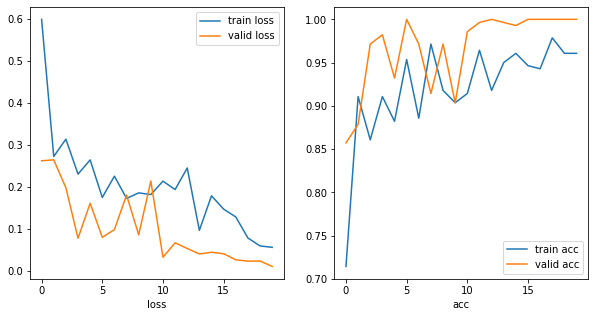

In [12]:
# 用作调参
train(model, train_data, valid_data, max_epoch, criterion, optimizer)

In [13]:
# 保存模型
torch.save(model.state_dict(), './model/save_model2.pth')